<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        <h4>Objectives:</h4>
        The primary objective of this project is to develop predictive models for DNA sequence gene classification.
        <h4>Dataset:</h4>
        The dataset files contain genetic sequence data in FASTA format. The dataset consists of two files:
        <ul>
            <li>Arabidopsis_thaliana_BHLH_gene_Family.fasta</li>
            <li>Arabidopsis_thaliana_CYP_gene_Family.fasta</li>
        </ul>
        <h4>Steps:</h4>
        <ol>
            <li>Read the genetic sequence data from the files.</li>
            <li>Vectorize the data to prepare it for modeling.</li>
            <li>Implement classification models such as k-nearest neighbors (kNN), support vector machine (SVM), and random forest (RF).</li>
            <li>Evaluate the performance of the models using appropriate metrics.</li>
            <li>Iterate on model tuning and feature selection to improve classification accuracy.</li>
            <!-- Add more steps as needed -->
        </ol>
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Sequential
import matplotlib.pyplot as plt

### 2 - Importing Dataset
The following function will read each **.fasta file** and return a pandas dataframe in this format [**id** - **sequence** - **length** - **class**]

In [3]:
def read_fasta_file(file_path, family):
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

In [15]:
# Data file path
gene_family_1 = "./Content/Data/Arabidopsis_thaliana_BHLH_gene_Family.fasta"
gene_family_2 = "./Content/Data/Arabidopsis_thaliana_CYP_gene_Family.fasta"

# Convert to dataframe:
dataset1 = read_fasta_file(gene_family_1, "BHLH")
dataset2 = read_fasta_file(gene_family_2, "CYP")

# Concatenate the two dataframes
dataset = pd.concat([dataset1, dataset2], ignore_index=True)

# Let's get a quick look at our dataset
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,BHLH
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,BHLH
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,BHLH
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,BHLH
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,BHLH


### 3 - Exploratory analysis

* Track null-value field

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        380 non-null    object
 1   sequence  380 non-null    object
 2   length    380 non-null    int64 
 3   class     380 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.0+ KB


**Note**: As we can see, our database contains 380 entries. In each column we have uniform data types and non-null data

* Track non coherent data

In [17]:
pattern = r'^[ATCG]+$'
assert dataset['sequence'].str.match(pattern).all(), "Error: Invalid characters found in sequence column"

**Note**: All sequences in the 'sequence' column contain only 'A', 'T', 'C', and 'G'. That sound good.

* Handling imbalanced data

In [18]:
class_counts = dataset['class'].value_counts()
total_samples = len(dataset)
class_counts_df = pd.DataFrame(class_counts)
class_counts_df.columns = ['Count']
class_counts_df['Percentage'] = (class_counts_df['Count'] / total_samples * 100).round(2)

print("Class Distribution:")
print(class_counts_df)
print("\nTotal Samples:", total_samples)

Class Distribution:
       Count  Percentage
class                   
CYP      218       57.37
BHLH     162       42.63

Total Samples: 380


In [19]:
# Calculate the imbalance ratio
imbalance_ratio = class_counts_df['Count'].max() / class_counts_df['Count'].min()
imbalance_threshold = 1.5
print("Imbalance Ratio:", imbalance_ratio)
print("The data is imbalanced." if imbalance_ratio >= imbalance_threshold else "The data is not significantly imbalanced.")

Imbalance Ratio: 1.345679012345679
The data is not significantly imbalanced.


**Note**: We can see that our dataset is imbalanced. Then we have to create a balanced dataset from the imbalanced one. We can use techniques like oversampling or undersampling. But as we do not have enough data, we are going to make **random oversampling from minority class**

In [20]:
def balance_dataset(df):
    df_majority = df[df['class'] == 'CYP']
    df_minority = df[df['class'] == 'BHLH']
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)    
    df_balanced = pd.concat([df_majority, df_minority_upsampled], ignore_index=True)
    return df_balanced

if imbalance_ratio >= imbalance_threshold:
    dataset = balance_dataset(dataset)
    print(dataset['class'].value_counts())

* Let encode label

In [21]:
dataset['class'] = LabelEncoder().fit_transform(dataset['class'])

output_path   = "./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv"
dataset.to_csv(output_path, index=False)

dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


#### 4 - Prediction with NN
The idea of ​​this first part is to try to represent the DNA strands as images and to see if our model can identify specific patterns. We will convert each DNA strand into a 2D array. Then we will adapt it to a CNN to perform the classification.

##### 4-1 - Preprocessing

In [222]:
dataset_nn = dataset.copy()
dataset_nn.describe()

,length,class
count,436.000000,436.000000
mean,2079.940367,0.500000
std,737.394279,0.500574
min,468.000000,0.000000
25%,1668.750000,0.000000
50%,1936.000000,0.500000
75%,2402.500000,1.000000
max,4873.000000,1.000000


In [223]:
# dataset_nn
print(len(dataset_nn["sequence"][0]))
print(len(dataset_nn["sequence"][1]))

1981
1961


**Note**: Our sequences do not have same size. We will pad to reach max_length. And convert each of then using one_hot_encoding

In [224]:
from utils.DNA_Utils import DNA

In [247]:
max_length = dataset_nn['sequence'].apply(lambda x: len(x)).min()
#max_length = int(dataset_nn['sequence'].apply(lambda x: len(x)).quantile(0.75))
max_length

468

In [248]:
sequences = list(dataset_nn['sequence'])
X = DNA.one_hot_encoding(sequences, max_length)
X.shape

(436, 468, 4)

In [249]:
y = dataset_nn['class'].values
y.shape

(436,)

In [250]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

##### 4-2 Build CNN Model

In [251]:
def build_cnn(output_layer_units=2, max_length_seq=100):
    model = Sequential(name="DNA_CLASSIFIER_1")

    # Add the Input layer first
    model.add(Input(shape=(max_length_seq, 4, 1)))
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(output_layer_units, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [252]:
model = build_cnn(output_layer_units=1, max_length_seq=max_length)

Model: "DNA_CLASSIFIER_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 468, 4, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 234, 2, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 234, 2, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 117, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 7488)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       479,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,177 (1.90 MB)

 Trainable params: 498,177 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [253]:
def train_model(model, X, y, validation_split=0.1, epochs=10, batch_size=None, verbose=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, stratify=y)

    # Callback
    stop_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=0,
    )

    # Build model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[])
    if not verbose:
      print(f"validation_accuracy = {np.max(history.history['val_accuracy'])}")
    return history

In [254]:
# Helper plotting function
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m, lw=2)
    plt.legend()

In [255]:
# Let's train the model
history = train_model(model, X_train, y_train, validation_split=0.2, epochs=32, batch_size=64)

Epoch 1/32


/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5115 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5280 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4848 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5124 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4993 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4983 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 7/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4985 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.0000e+00
Epoch 8/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4640 - loss: 0.00

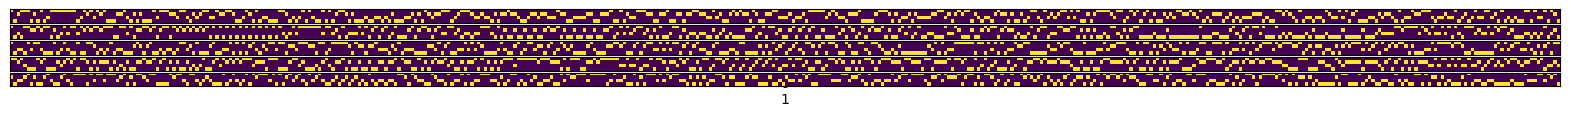

In [276]:
from random import randint
fig, axes = plt.subplots(5, 1,  figsize=(20,1))
for i in range(5):
    n = randint(0,len(X))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(X[n].T)
    axes[i].set_xlabel(int(y[n]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

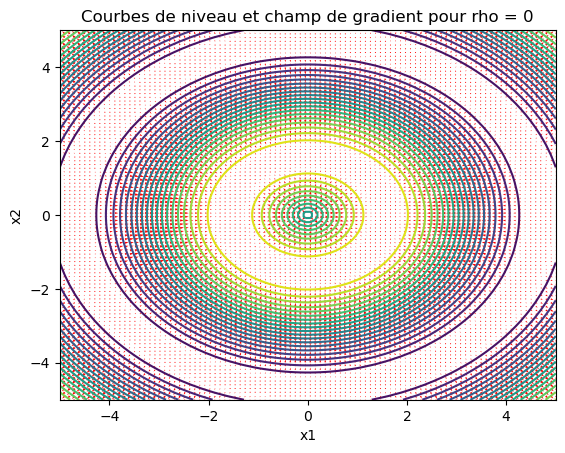

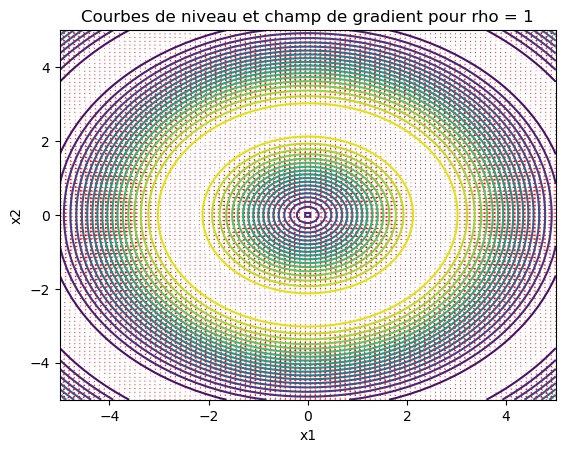

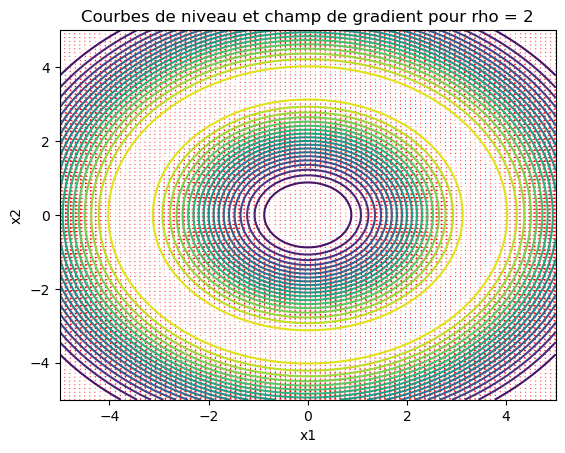

In [277]:
import numpy as np
import matplotlib.pyplot as plt

# Définir la fonction de coût et son gradient
def phi(x, y, rho):
    return np.sin(np.sqrt(x**2 + y**2) - rho)

def gradient_phi(x, y, rho):
    r = np.sqrt(x**2 + y**2)
    if r == 0:
        return np.array([0, 0])
    else:
        return np.array([(x * np.cos(r - rho) / r), (y * np.cos(r - rho) / r)])

# Définir les valeurs de rho
rho_values = [0, 1, 2]

# Créer une grille de points
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Tracer pour plusieurs valeurs de rho
for rho in rho_values:
    Z = phi(X, Y, rho)
    U, V = np.zeros(X.shape), np.zeros(Y.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            grad = gradient_phi(X[i, j], Y[i, j], rho)
            U[i, j], V[i, j] = grad
    
    plt.figure()
    plt.contour(X, Y, Z, levels=20)
    plt.quiver(X, Y, U, V, color='red')
    plt.title(f"Courbes de niveau et champ de gradient pour rho = {rho}")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()